In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

from data_reader import read_data
from data_preprocessing import preprocess_data
from feature_extractor import extract_features

%matplotlib inline

In [2]:
# data = preprocess_data(read_data(), limit=1000000, normalize_text=True, save_file='result.cropped.1m.tsv', verbose=True)
data = preprocess_data(read_data('result.cropped.1m.tsv'))

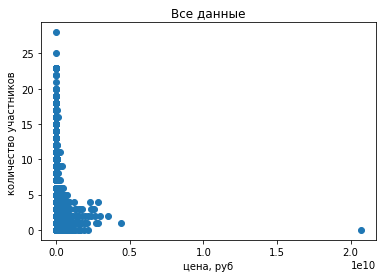

In [3]:
plt.scatter(data['RubPrice'], data['SuppliersCount'])
plt.title("Все данные")
plt.xlabel("цена, руб")
plt.ylabel("количество участников ")
plt.show()

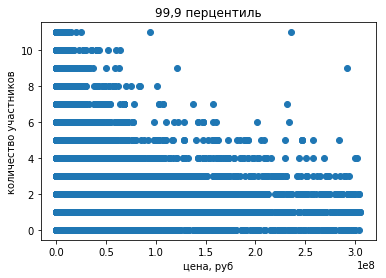

In [4]:
data_nn = data[(~np.isnan(data['RubPrice'])) & (~np.isnan(data['SuppliersCount']))]
data95 = data_nn[(data_nn['RubPrice'] < np.percentile(data_nn['RubPrice'], 99.9)) &
                 (data_nn['SuppliersCount'] < np.percentile(data_nn['SuppliersCount'], 99.9))]
plt.scatter(data95['RubPrice'], data95['SuppliersCount'])
plt.title("99,9 перцентиль")
plt.xlabel("цена, руб")
plt.ylabel("количество участников")
plt.show()

In [5]:
data.SuppliersCount.value_counts()

1.0     245676
2.0     206090
0.0     186692
3.0     137898
4.0      94266
5.0      57868
6.0      32789
7.0      18197
8.0       9997
9.0       5357
10.0      2604
11.0      1295
13.0       522
12.0       378
14.0       150
15.0        95
16.0        58
23.0        20
17.0        18
18.0        12
19.0         7
20.0         5
22.0         3
28.0         1
25.0         1
21.0         1
Name: SuppliersCount, dtype: int64

In [6]:
len(data['CurrencyCode'].unique())

4

In [7]:
len(data['ProcedureDisplayName'].unique())

24

In [8]:
data_unbalanced = data.head(100000)
features_unbalanced, pca_ = extract_features(data_unbalanced, use_pca=True,
                                             title_features=1000, pca_features=500, verbose=True)

oh CurrencyCode
oh ProcedureDisplayName
oh Ogrn
ng Title
ng ProcedureDisplayName
ng OrgName
[2019-04-19 16:39:52.758105]: start pca
[2019-04-19 16:40:23.759291]: end pca
354
0.9002139005329667


Text(0, 0.5, 'explained_variance_')

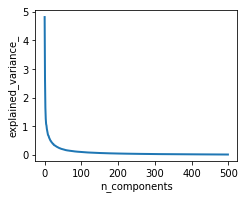

In [9]:
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca_.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

In [10]:
def ngrams(data, column):
    return data.columns[data.columns.str.startswith(f'Ngrams_{column}_')].tolist()

def onehots(data, column):
    return data.columns[data.columns.str.startswith(f'OneHot_{column}_')].tolist()

def pcas(data, column):
    return data.columns[data.columns.str.startswith(f'pca_{column}_')].tolist()

In [11]:
X = features_unbalanced[ngrams(features_unbalanced, 'Title') + ['RubPrice']]
y = data_unbalanced['SuppliersCount']
len(X), len(y)

(100000, 100000)

In [12]:
X_pca = features_unbalanced[pcas(features_unbalanced, 'Title') + ['RubPrice']]

In [13]:
cross_val_score(LinearRegression(), X, y, cv=3, scoring='r2').mean()

0.11059420114084491

In [14]:
cross_val_score(LinearRegression(), X_pca, y, cv=3, scoring='r2').mean()

-0.00045648256585277086

In [15]:
cross_val_score(DummyRegressor(), X, y, cv=3, scoring='r2').mean()

-0.00026280735446955933

In [16]:
from sklearn.svm import LinearSVR
cross_val_score(LinearSVR(), X, y, cv=3, scoring='neg_mean_squared_error').mean()

-68458.67939065606

In [17]:
from sklearn.ensemble import RandomForestRegressor
cross_val_score(RandomForestRegressor(), X, y, cv=3, scoring='neg_mean_squared_error').mean()

C:\Users\chikurova\Anaconda2\envs\py36\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


-2.7640290636668006

In [18]:
X = features_unbalanced[ngrams(features_unbalanced, 'Title') + ngrams(features_unbalanced, 'ProcedureDisplayName')]
cross_val_score(Ridge(), X, y, cv=3, scoring='neg_mean_squared_error').mean()

-2.490751303132549

In [19]:
X = features_unbalanced[pcas(features_unbalanced, 'Title') + ngrams(features_unbalanced, 'ProcedureDisplayName')]
cross_val_score(Ridge(), X, y, cv=3, scoring='neg_mean_squared_error').mean()

-2.481998243547916

In [20]:
X = features_unbalanced[ngrams(features_unbalanced, 'Title') + onehots(features_unbalanced, 'ProcedureDisplayName')]
cross_val_score(Ridge(), X, y, cv=3, scoring='neg_mean_squared_error').mean()

-2.4906059172202397

In [21]:
X = features_unbalanced[pcas(features_unbalanced, 'Title') + onehots(features_unbalanced, 'ProcedureDisplayName')]
cross_val_score(Ridge(), X, y, cv=3, scoring='neg_mean_squared_error').mean()

-2.481920243844287

In [22]:
cross_val_score(Ridge(), X, y, cv=3, scoring='neg_mean_absolute_error').mean()

-1.036454205417651

In [23]:
X = features_unbalanced[ngrams(features_unbalanced, 'Title') + ngrams(features_unbalanced, 'ProcedureDisplayName')]
cross_val_score(Lasso(), X, y, cv=3, scoring='neg_mean_squared_error').mean()

-3.2018867450420925

In [24]:
X = features_unbalanced[ngrams(features_unbalanced, 'Title') + onehots(features_unbalanced, 'ProcedureDisplayName')]
cross_val_score(Lasso(), X, y, cv=3, scoring='neg_mean_squared_error').mean()

-3.2018867450420925

In [25]:
param_grid = {'alpha': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]}
optimizer = GridSearchCV(Ridge(), param_grid, scoring='neg_mean_squared_error', cv=3)
optimizer.fit(X, y)
optimizer.best_estimator_.coef_, optimizer.best_score_

(array([-0.00759646, -0.14228848, -0.06165267, ..., -0.07475171,
         1.28509183, -0.18633376]), -2.4798515440706503)

In [26]:
X = features_unbalanced[ngrams(features_unbalanced, 'Title') + onehots(features_unbalanced, 'ProcedureDisplayName') + ['RubPrice']]
cross_val_score(Ridge(), X, y, cv=3, scoring='neg_mean_squared_error').mean()

C:\Users\chikurova\Anaconda2\envs\py36\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.735485e-20
  overwrite_a=True).T
C:\Users\chikurova\Anaconda2\envs\py36\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.479297e-20
  overwrite_a=True).T
C:\Users\chikurova\Anaconda2\envs\py36\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.762665e-20
  overwrite_a=True).T


-2.4904375964575634

In [27]:
g = data.groupby('SuppliersCount')
data_balanced = g.apply(lambda x: x.head(8095)).sample(frac=1).reset_index(drop=True)
data_balanced

,Unnamed: 0,index,id,Title,Uri,PublicationDateTimeUTC,ProcedureDisplayName,Amount,RubPrice,CurrencyCode,...,StatusCode,SuppliersCount,IsWinner,ResultClass,Inn,Kpp,Name,Ogrn,ogrn1,Ogrn1
0,630616,634400,0120300000717000016,услуга типография изготовление поздравительный...,https://zakupki.kontur.ru/0120300000717000016,2017-09-05,электронный аукцион,67435.00,67435.00,RUB,...,2.0,8.0,1.0,1.0,2511032253,NaN,ДУМА УССУРИЙСКОГО ГОРОДСКОГО ОКРУГА,1022500867806,1,25
1,748659,752518,0124200000616007033,поставка линолеум,https://zakupki.kontur.ru/0124200000616007033,2016-11-28,электронный аукцион,391650.00,391650.00,RUB,...,2.0,8.0,1.0,1.0,2902031265,NaN,ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХР...,1022900843239,1,29
2,94714,95317,0107300001216000559,выполнение работа по перевозка пассажир и бага...,https://zakupki.kontur.ru/0107300001216000559,2016-10-25,электронный аукцион,57600.00,57600.00,RUB,...,2.0,4.0,1.0,1.0,1102024570,NaN,АДМИНИСТРАЦИЯ МУНИЦИПАЛЬНОГО ОБРАЗОВАНИЯ ГОРОД...,1021100735810,1,11
3,340795,341408,0113300025716000244,электронный аукцион на поставка картофель в пе...,https://zakupki.kontur.ru/0113300025716000244,2016-07-20,электронный аукцион,2131290.00,2131290.00,RUB,...,2.0,15.0,1.0,1.0,1832026570,NaN,МУНИЦИПАЛЬНОЕ БЮДЖЕТНОЕ ДОШКОЛЬНОЕ ОБРАЗОВАТЕЛ...,1021801435820,1,18
4,117128,117736,0109200002417000616,закупка лекарственный препарат с мнн цефтриаксон,https://zakupki.kontur.ru/0109200002417000616,2017-04-12,электронный аукцион,855200.00,855200.00,RUB,...,2.0,12.0,1.0,1.0,1326045383,NaN,ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХР...,1021300974760,1,13
5,32010,32033,0102200001615006091,поставка лекарственный препарат амброксол,https://zakupki.kontur.ru/0102200001615006091,2015-12-21,электронный аукцион,23182.50,23182.50,RUB,...,2.0,2.0,1.0,1.0,0312002268,NaN,ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХР...,1020300715742,1,3
6,39260,39284,0102200001617002410,поставка микроскоп медицинский,https://zakupki.kontur.ru/0102200001617002410,2017-06-05,электронный аукцион,165483.08,165483.08,RUB,...,2.0,3.0,1.0,1.0,0323054067,NaN,ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХР...,1020300901631,1,3
7,337774,338387,0113300025716000195,электронный аукцион на поставка мясо птица в п...,https://zakupki.kontur.ru/0113300025716000195,2016-05-26,электронный аукцион,9936636.00,9936636.00,RUB,...,2.0,8.0,1.0,1.0,1832026732,NaN,МУНИЦИПАЛЬНОЕ БЮДЖЕТНОЕ ДОШКОЛЬНОЕ ОБРАЗОВАТЕЛ...,1021801435226,1,18
8,9357,9366,0101200009516003391,электронный аукцион g0007492864137g на право з...,https://zakupki.kontur.ru/0101200009516003391,2016-08-24,электронный аукцион,532416.00,532416.00,RUB,...,2.0,7.0,1.0,1.0,0269004241,NaN,ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ СТАЦИОНАРНОЕ УЧРЕЖДЕ...,1020202214746,1,2
9,33744,33767,0102200001616002448,поставка средство действующий на центральный н...,https://zakupki.kontur.ru/0102200001616002448,2016-05-06,электронный аукцион,308952.92,308952.92,RUB,...,2.0,2.0,1.0,1.0,0323051250,NaN,ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХР...,1020300966289,1,3


In [28]:
features_balanced, _ = extract_features(data_balanced)
X = features_balanced[ngrams(features_balanced, 'Title') + ['RubPrice']]
y = data_balanced['SuppliersCount']

C:\Users\user\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used

oh CurrencyCode
oh ProcedureDisplayName


C:\Users\user\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


oh Ogrn
ng Title
ng ProcedureDisplayName
ng OrgName


In [29]:
cross_val_score(DummyRegressor(), X, y, cv=3, scoring='r2').mean()

-4.170449937057619e-05

In [30]:
X = features_balanced[ngrams(features_balanced, 'Title') + onehots(features_balanced, 'ProcedureDisplayName')]
cross_val_score(Ridge(), X, y, cv=3, scoring='r2').mean()

0.5410690512192006

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123456)

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# bagging_parameters = {
#     "max_samples": [0.5, 1.0],
#     "max_features": [0.5, 1.0],
#     "bootstrap": [True, False],
#     "bootstrap_features": [True, False]
# }

# dummy_parameters = {"base_estimator__strategy": ["mean", "median"]}

# tree_parameters = {'base_estimator__max_features': ['sqrt', 'log2', None],
#                    'base_estimator__max_depth': list(np.arange(3, 16, 3))}

# neighbors_parameters = {'base_estimator__weights': ['uniform', 'distance'],
#                         'base_estimator__n_neighbors': list(np.arange(50, 200, 50))}

# svr_parameters = {'base_estimator__kernel': ['linear', 'rbf','poly'],
#                   'base_estimator__C': [0.1, 1, 10]}

# base_estimators = [
#     (DummyRegressor(), dummy_parameters),
#     (DecisionTreeRegressor(), tree_parameters),
#     (SVR(gamma='scale'), svr_parameters),
#     (KNeighborsRegressor(), neighbors_parameters),
# ]

# for (estimator, estimator_parameters) in base_estimators:
#     parameters = {}
#     parameters.update(bagging_parameters)
#     parameters.update(estimator_parameters)
#     print(parameters)
#     grid_search = GridSearchCV(BaggingRegressor(base_estimator=estimator),
#                                parameters,
#                                scoring="r2", verbose=100, n_jobs=15)
#     grid_search.fit(X, y)
#     print(grid_search.best_params_)

In [33]:
# from sklearn.model_selection import GridSearchCV
# from xgboost import XGBRegressor

# param_grid = {
#     'min_child_weight':[2, 3, 4, 5], 
#     'gamma':[i / 10.0 for i in range(1, 4)],  
#     'subsample':[i / 10.0 for i in range(9, 11)],
#     'colsample_bytree':[i / 10.0 for i in range(9, 11)], 
#     'max_depth': [4, 5, 6, 7]
# }

# xgb_reg= XGBRegressor(n_estimators, 100, nthread=-1, n_jobs=-1, random_state=42) 

# grid = GridSearchCV(xgb_reg, param_grid, cv=5, verbose=10, scoring="r2")
# grid.fit(X, y)
# print(grid.best_params_)
# print(grid.best_score_)

In [34]:
# from sklearn.model_selection import GridSearchCV
# from xgboost import XGBRegressor

# xgb_reg= XGBRegressor(n_estimators=100, nthread=-1, n_jobs=-1, random_state=42, 
#                       colsample_bytree=0.9, gamma=0.2, max_depth=8, min_child_weight=6, subsample=0.9) 

# cross_val_score(xgb_reg, X, y, cv=3, scoring='r2').mean()

In [35]:
# import lightgbm as lgb
# from sklearn.model_selection import GridSearchCV
# param_grid = {
#     'learning_rate': [0.005, 0.01, 0.1],
#     'num_leaves': [6, 8, 12, 16, 31],
#     'boosting_type' : ['gbdt', 'dart'],
#     'subsample':[i / 10.0 for i in range(6, 11)],
#     'colsample_bytree':[i / 10.0 for i in range(6, 11)]
#     }

# gbm = lgb.LGBMRegressor(n_estimators=100, random_state=42)

# grid_lgb = GridSearchCV(gbm, param_grid, cv=5, verbose=10, scoring="r2")
# grid_lgb.fit(X, y)
# print(grid_lgb.best_params_)
# print(grid_lgb.best_score_)

In [61]:
# clf = BaggingRegressor(base_estimator=DummyRegressor(strategy='median'), 
#                        n_estimators=500, bootstrap = True, bootstrap_features=True,
#                        max_samples=0.5, max_features=0.5, random_state=123456)

# clf = BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=14), 
#                        n_estimators=100, bootstrap = True, bootstrap_features=True,
#                        max_samples=0.5, max_features=1.0, random_state=123456, verbose=100)
# clf = RandomForestRegressor(n_estimators=100, verbose=True)
# clf = DummyRegressor()

# from xgboost import XGBRegressor
# clf =  XGBRegressor(n_estimators=100, nthread=-1, n_jobs=-1, random_state=42, 
#                       colsample_bytree=0.9, gamma=0.2, max_depth=8, min_child_weight=6, subsample=0.9) 

import lightgbm as lgb
clf = lgb.LGBMRegressor(num_leaves=31, learning_rate=0.1, colsample_bytree=0.9, subsample=0.8, 
                        metric='mse', objective='mse', n_estimators=2000, random_state=42, max_depth=20)

clf.fit(X_train, y_train)
pred = clf.predict(X_test)

In [62]:
print("MSE: ", mean_squared_error(pred, y_test))
print("MAE: ", mean_absolute_error(pred, y_test))
print("R2: ", r2_score(pred, y_test))

MSE:  2.598907732221342
MAE:  0.9600309484970666
R2:  0.6665829980187203


In [38]:
data.head()

,Unnamed: 0,index,id,Title,Uri,PublicationDateTimeUTC,ProcedureDisplayName,Amount,RubPrice,CurrencyCode,...,StatusCode,SuppliersCount,IsWinner,ResultClass,Inn,Kpp,Name,Ogrn,ogrn1,Ogrn1
0,0,0,0100600000117000001,закупка товар работа услуга в соответствие с п...,https://zakupki.kontur.ru/0100600000117000001,2017-04-13,закупка у единственный поставщик подрядчик исп...,1310000.0,1310000.0,RUB,...,2.0,0.0,0.0,0.0,4720008346,NaN,МЕСТНАЯ АДМИНИСТРАЦИЯ МУНИЦИПАЛЬНОГО ОБРАЗОВАН...,1024702184451,1,47
1,1,1,0100600000117000002,закупка товар работа услуга в соответствие с п...,https://zakupki.kontur.ru/0100600000117000002,2017-04-13,закупка у единственный поставщик подрядчик исп...,249000.0,249000.0,RUB,...,2.0,0.0,0.0,0.0,4720008346,NaN,МЕСТНАЯ АДМИНИСТРАЦИЯ МУНИЦИПАЛЬНОГО ОБРАЗОВАН...,1024702184451,1,47
2,2,2,0100600000117000003,закупка товар работа услуга в соответствие с п...,https://zakupki.kontur.ru/0100600000117000003,2017-07-06,закупка у единственный поставщик подрядчик исп...,250000.0,250000.0,RUB,...,2.0,0.0,0.0,0.0,4720008346,NaN,МЕСТНАЯ АДМИНИСТРАЦИЯ МУНИЦИПАЛЬНОГО ОБРАЗОВАН...,1024702184451,1,47
3,3,3,0100600000117000004,выполнение работа по ремонт автомобильный доро...,https://zakupki.kontur.ru/0100600000117000004,2017-07-06,запрос котировка,400300.0,400300.0,RUB,...,2.0,2.0,1.0,1.0,4720008346,NaN,МЕСТНАЯ АДМИНИСТРАЦИЯ МУНИЦИПАЛЬНОГО ОБРАЗОВАН...,1024702184451,1,47
4,4,4,0100600000117000005,приобретение и установка спортивный оборудование,https://zakupki.kontur.ru/0100600000117000005,2017-07-10,запрос котировка,451000.0,451000.0,RUB,...,2.0,1.0,0.0,0.0,4720008346,NaN,МЕСТНАЯ АДМИНИСТРАЦИЯ МУНИЦИПАЛЬНОГО ОБРАЗОВАН...,1024702184451,1,47
